In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import Yukawa_SINDy as ys
import pysindy as ps
from importlib import reload

/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py:706: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title("simulation duration: " + str(sim_duration) + "$\omega_{pd}$")
/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py:709: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("max ptcl sep ($\lambda_{De}$)")
/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py:723: SyntaxWarning: invalid escape sequence '\l'
  axs[i].set_title("Cutoff: " + str(cutoffs[i]) + "$\lambda_{De}$", fontsize=14)
/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py:725: SyntaxWarning: invalid escape sequence '\o'
  fig.supxlabel('duration ($\omega_{pd}^{-1}$)')
/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py:727: SyntaxWarnin

In [7]:
# included to update Yukawa_SINDy.py version used in this notebook as changes are made
reload(ys)

<module 'Yukawa_SINDy' from '/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py'>

In [8]:
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)

list of functions exported to 'Yukawa_SINDy.py'

- `generate_training_data`
- `plot_complexities`
- `scan_thresholds`
- `generate_libraries`

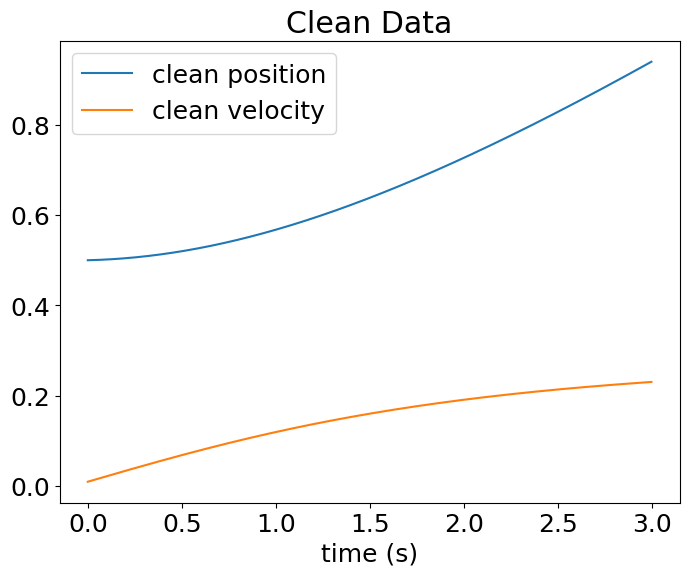

In [9]:
testsim = ys.Yukawa_simulation()
testsim.simulate(3, 0.001, 0.5,0.01,scaled=True)
testsim.plot()

In [ ]:
positions = testsim.x[:,0]
avg_pos = np.average(np.abs(positions))
rms_pos = np.sqrt(np.sum(positions**2) / len(positions))
print("avg position:", avg_pos)
print("rms position:", rms_pos)
velocities = testsim.x[:,1]
avg_vel = np.average(np.abs(velocities))
rms_vel = np.sqrt(np.sum(velocities**2) / len(velocities))
print("avg velocity:", avg_vel)
print("rms velocity:", rms_vel)

In [ ]:
# add noise and calculate signal-to-noise ratio (SNR) using avg positions
noise_level = 0.01
testsim.add_gaussian_noise(noise_level)

In [ ]:
SNR_pos = avg_pos / noise_level
SNR_pos_dB = 10*np.log10(SNR_pos)
print("position SNR (dB):", SNR_pos_dB)
SNR_vel = avg_vel / noise_level
SNR_vel_dB = 10*np.log10(SNR_vel)
print("velocity SNR (dB):", SNR_vel_dB)

# Analysis of Yukawa 2-body data using Weak SINDy

## `std_dev=0.01`

In [ ]:
# set var 'noise_level' for this section
noise_level = 0.01

The purpose of this notebook is to use a weak SINDy analysis on 2-body trajectories to see if the sparse recovery of simulation coefficients is improved. Results from the analysis of the same system using only one trajectory with strong-form SINDy (the original formulation) is shown in the notebook 'Yukawa2body.ipynb'.

Here, we will start by using one trajectory of the 2-body equations, as we did before, and then possibly extend to more trajectories.

In [ ]:
sim001 = ys.Yukawa_simulation()
sim001.simulate(5, dt=0.001, x0=0.5, v0=0.01, scaled=True)
sim001.add_gaussian_noise(noise_level=noise_level)
sim001.plot()

In [ ]:
thresholds = np.arange(0, A, 0.05*A)
thresholds, complexities = ys.scan_thresholds(sim001, thresholds, verbose=True)

In [ ]:
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

the model is fit at `threshold=0.35*A` to a very good approximation with the weak formulation. In this parameter range, the strong form does not really come close to the correct equation.

In [ ]:
thresholds = np.arange(0, 10*A, 0.5*A)
thresholds, complexities = ys.scan_thresholds(sim001, thresholds, verbose=True)
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

From this, we can see that strong form discovers nothing meaningful, even when the threshold is at $10A$.

In [ ]:
# code to be used for spot checking whatever threshold
threshold = 0.35*A
opt = ps.STLSQ(threshold=threshold)
weak_lib, strong_lib = ys.generate_libraries(sim001.t)
weak_model = ps.SINDy(feature_names=["x", "v"], feature_library=weak_lib, optimizer=opt)
weak_model.fit(sim001.x)
weak_model.print(precision=5)

## `std_dev=0.10`

In [ ]:
noise_level=0.10

In [ ]:
sim010 = ys.Yukawa_simulation()
sim010.simulate(5, dt=0.001,x0=0.5,v0=0.01,scaled=True)
sim010.add_gaussian_noise(noise_level=noise_level)
sim010.plot()

In [ ]:
thresholds = np.arange(0, 2*A, 0.2*A)
print(thresholds)
print(thresholds/A)

In [ ]:
thresholds = np.arange(0, 1*A, 0.02*A)
thresholds, complexities = ys.scan_thresholds(sim010, thresholds, verbose=True)
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

With a single trajectory, WSINDy does not recover the correct equations of motion, but it does discover the leading terms along with the presence of extraneous terms. This improves with the multiple trajectories approach.

## Multiple trajectories

We can also generate many trajectories with different initial conditions and use that to train SINDy. This is what we were already doing for the three-body case, but we can see how much it improves the performance of SINDy here.

Note that we generate random initial conditions in the following way:

- *Initial positions*: taken from a normal distribution centered at 1 with std. dev. of 0.2
- *Initial velocities*: taken from a normal distribution centered at 0.01 with a std. dev. of 0.002, also with a random +/- sign.

This was done carefully so as to avoid there being zeros in the initial conditions, which create problems for the solver and for SINDy because of the presence of the rational terms.

### `noise_level=0.01`

In [ ]:
# change 'noise_level' back to 0.01
noise_level = 0.01

In [ ]:
sims001 = ys.generate_training_data(noise_level=noise_level, scaled=True, mu_x0s=0.5)
sims001[73].plot()

In [ ]:
sims001[100].is_scaled

In [ ]:
thresholds = np.arange(0, 0.2*A, 0.01*A)
thresholds, complexities = ys.scan_thresholds(sims001, thresholds, verbose=True)

So the "correct model" is discovered by the weak form when `threshold=0.04*A` with no small extraneous terms.

In [ ]:
ys.plot_complexities(thresholds,complexities, noise_level)

### `noise_level=0.10`

In [ ]:
noise_level = 0.10

In [ ]:
sims010 = ys.generate_training_data(noise_level=noise_level, mu_x0s=0.5, scaled=True)

In [ ]:
sims010[38].plot()

In [ ]:
# thresholds = np.arange(0, 0.2, 0.01)
thresholds = np.concatenate((np.arange(0, 0.2*A, 0.01*A), np.arange(0.2*A, 1.0*A, 0.05*A), np.arange(1.0*A, 5.0*A, 0.5*A)))
libs = ys.generate_libraries(sims010[0].t)
x_train010 = [sim.x for sim in sims010]
t_train010 = sims010[0].t
thresholds, complexities = ys.scan_thresholds(sims010, thresholds, verbose=True)

In [ ]:
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

Noticing as these models are coming out that there is a long series of the exact same models between 0.05 and 0.18 in the weak case, with a few steps happening for the strong models. 
It might be interesting to look into an optimal threshold step size that would minimize SINDy discovering the same model over and over again.

In [ ]:
x_train = [sim.x for sim in sims010] # if sim.x.shape[0] == 5000]
t_train = sims010[0].t
weak_lib, strong_lib = generate_libraries(t_train)
opt = ps.STLSQ(threshold=0.5)
strong_model = ps.SINDy(feature_names=["x", "v"],feature_library=strong_lib, optimizer=opt)
strong_model.fit(x_train, t=t_train, multiple_trajectories=True)
strong_model.print(precision=5)

In [ ]:
opt = ps.STLSQ(threshold=0.2)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)

The weak form of SINDy discovers the correct underlying model with a threshold of 0.2, while strong-form SINDy does not discover the correct model.

### `noise_level=0.20`

In [ ]:
noise_level=0.20

### `noise_level=0.50`

In [ ]:
noise_level=0.50

In [ ]:
# code for spot-checking weak models
x_train = [sim.x for sim in sims050]
t_train = sims050[0].t

weak_lib, strong_lib = generate_libraries(t_train)
opt = ps.STLSQ(threshold=0.0001)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)